In [1]:
import numpy as np
import matplotlib.pyplot as plt
import mpld3
import pandas as pd
import os
from HelperFunctions import *
from PtOccupancyFunctions import *
import scipy.integrate
import pprint
import re

In [2]:
# path = "/home/helge/Applications/matsim/matsim-bimodal/scenarios/fine_grid/bimodal/output/merge/"
path = "/home/helge/Applications/matsim/matsim_results_ssd/PeriodicBC/8DrtCap/OwnIntermodalAccEgr/OptDrtCount/SmallLinks/125e3Reqs/Fine2Merged2Combined/"

In [3]:
def getDirsFleetSizes(directory, mode="bimodal"):
    result = []
    sub_dirs = []
    sdirs = [
        sdir.path
        for sdir in
            os.scandir(directory)
        if sdir.is_dir() and "drt" in sdir.name
    ]

    for sdir in sorted(sdirs, key=lambda x: int(re.search("\d+",x.split("/")[-1])[0])):
        subresult = {}
        subresult["root"] = sdir
        for root, subdirs, files in os.walk(sdir):
            subroot = root.replace(directory,"")
            for file in files:
                if file=="0.trips.csv.gz" and mode in subroot:
                    subresult["trips"] = os.path.join(root, file)
                if file=="0.vehicleDistanceStats_drt.csv" and mode in subroot:
                    subresult["drt_dists"] = os.path.join(root, file)
                if file=="trip_success.csv.gz" and mode in subroot:
                    subresult["trip_success"] = os.path.join(root, file)
                if file=="0.CummulativePtDistance.txt" and mode in subroot:
                    subresult["pt_dist"] = os.path.join(root, file)
                if file=="0.drt_occupancy_time_profiles_drt.txt" and mode in subroot:
                    subresult["drt_occupancy"] = os.path.join(root, file)
                if file=="0.occupancyAnalysis.txt" and mode in subroot:
                    subresult["pt_occupancy"] = os.path.join(root, file)
                if file=="0.drt_trips_drt.csv" and mode in subroot:
                    subresult["drt_trips"] = os.path.join(root, file)
                if file=="0.drt_detours_drt.csv" and mode in subroot:
                    subresult["drt_detours"] = os.path.join(root, file)
                if file=="ph_modestats.txt" and mode in subroot:
                    subresult["ph_modestats"] = os.path.join(root, file)
                if file=="pkm_modestats.txt" and mode in subroot:
                    subresult["pkm_modestats"] = os.path.join(root, file)
                    
        result.append(subresult)
    
    return result

def getCarDir(directory):
    result = {}
    result["root"] = getDir(directory, "car")
    for root, subdirs, files in os.walk(result["root"]):
        for file in files:
            if file=="0.trips.csv.gz":
                result["trips"] = os.path.join(root, file)
            if file=="trip_success.csv.gz" and "unimodal" not in root:
                result["trip_success"] = os.path.join(root, file)
    
    return result

def getDir(path, directory):
    for root, subdirs, files in os.walk(path):
        for subdir in subdirs:
            if subdir == directory:
                return os.path.join(root, subdir)

bim_dirs = getDirsFleetSizes(path, "unimodal")
# car_dir = getCarDir(path)
n_sims = len(bim_dirs)
print(n_sims)

77


In [4]:
pprint.pprint(bim_dirs)
# print('\n---\n')
# pprint.pprint(uni_dirs)
print('\n---\n')
pprint.pprint(car_dir)

[{'drt_detours': '/home/helge/Applications/matsim/matsim_results_ssd/PeriodicBC/8DrtCap/OwnIntermodalAccEgr/OptDrtCount/SmallLinks/125e3Reqs/Fine2Merged2Combined/350drt/unimodal/ITERS/it.0/0.drt_detours_drt.csv',
  'drt_dists': '/home/helge/Applications/matsim/matsim_results_ssd/PeriodicBC/8DrtCap/OwnIntermodalAccEgr/OptDrtCount/SmallLinks/125e3Reqs/Fine2Merged2Combined/350drt/unimodal/ITERS/it.0/0.vehicleDistanceStats_drt.csv',
  'drt_occupancy': '/home/helge/Applications/matsim/matsim_results_ssd/PeriodicBC/8DrtCap/OwnIntermodalAccEgr/OptDrtCount/SmallLinks/125e3Reqs/Fine2Merged2Combined/350drt/unimodal/ITERS/it.0/0.drt_occupancy_time_profiles_drt.txt',
  'drt_trips': '/home/helge/Applications/matsim/matsim_results_ssd/PeriodicBC/8DrtCap/OwnIntermodalAccEgr/OptDrtCount/SmallLinks/125e3Reqs/Fine2Merged2Combined/350drt/unimodal/ITERS/it.0/0.drt_trips_drt.csv',
  'ph_modestats': '/home/helge/Applications/matsim/matsim_results_ssd/PeriodicBC/8DrtCap/OwnIntermodalAccEgr/OptDrtCount/SmallL

  'pt_dist': '/home/helge/Applications/matsim/matsim_results_ssd/PeriodicBC/8DrtCap/OwnIntermodalAccEgr/OptDrtCount/SmallLinks/125e3Reqs/Fine2Merged2Combined/552drt/unimodal/ITERS/it.0/0.CummulativePtDistance.txt',
  'pt_occupancy': '/home/helge/Applications/matsim/matsim_results_ssd/PeriodicBC/8DrtCap/OwnIntermodalAccEgr/OptDrtCount/SmallLinks/125e3Reqs/Fine2Merged2Combined/552drt/unimodal/ITERS/it.0/0.occupancyAnalysis.txt',
  'root': '/home/helge/Applications/matsim/matsim_results_ssd/PeriodicBC/8DrtCap/OwnIntermodalAccEgr/OptDrtCount/SmallLinks/125e3Reqs/Fine2Merged2Combined/552drt',
  'trip_success': '/home/helge/Applications/matsim/matsim_results_ssd/PeriodicBC/8DrtCap/OwnIntermodalAccEgr/OptDrtCount/SmallLinks/125e3Reqs/Fine2Merged2Combined/552drt/unimodal/trip_success.csv.gz',
  'trips': '/home/helge/Applications/matsim/matsim_results_ssd/PeriodicBC/8DrtCap/OwnIntermodalAccEgr/OptDrtCount/SmallLinks/125e3Reqs/Fine2Merged2Combined/552drt/unimodal/ITERS/it.0/0.trips.csv.gz'},
 {'

NameError: name 'car_dir' is not defined

In [5]:
def getTrips(paths, mode):
    if mode == "bimodal":
        columns=["person","trav_time","wait_time","traveled_distance","modes"]
    elif mode == "unimodal":
        columns=["person","trav_time","wait_time"]
    elif mode == "car":
        columns=["person", "traveled_distance", "trav_time"]
    path = paths["trips"]
    df = pd.read_csv(path, sep=";").loc[:,columns]
    df["trav_time"] = df["trav_time"].apply(timestmp2sec)
    df.set_index("person", inplace=True)
    if mode=="car":
        df = df.groupby("person").agg(
            {
                "trav_time": np.sum,
                "traveled_distance": np.sum
            }
        )
        return df
    df["wait_time"] = df["wait_time"].apply(timestmp2sec)
    if mode=="unimodal":
        df = df.groupby("person").agg(
            {
                "trav_time": np.sum,
                "wait_time": np.sum,
            }
        )
        return df
    if mode == "bimodal":
        df = df.groupby("person").agg(
            {
                "trav_time": np.sum,
                "wait_time": np.sum,
                "traveled_distance": np.sum,
                "modes": combineModesSeriesStr,
            }
        )
        return df
    
def getFleetSize(path):
    return re.search("\d+", path.split("/")[-1])[0]

def getEll(path):
    return path.split("/")[-1].split("_")[-1]

def getModeStats(paths, columns_ph, columns_pkm):
    path_ph = paths["ph_modestats"]
    path_pkm = paths["pkm_modestats"]
    df_ph = pd.read_csv(path_ph, sep='\t').loc[:,columns_ph]
    df_pkm = pd.read_csv(path_pkm, sep='\t').loc[:,columns_pkm]
    return df_ph.to_numpy()[0], df_pkm.to_numpy()[0]

def getDrtVehicleDistances(paths):
    path = paths["drt_dists"]
    df = pd.read_csv(path, sep=";")["drivenDistance_m"]
    return df

def getTripSuccess(paths):
    path = paths["trip_success"]
    df = pd.read_csv(path, sep=";", index_col="personId")
    return df

def getCummulativePtDistance(paths):
    path = paths["pt_dist"]
    df = pd.read_csv(path).values[0, 0]
    return df

def getDrtOccupandyAndStandingFrac(paths, exclude_empty_vehicles, count_idle_vehicles=False):
    path = paths["drt_occupancy"]
    df = pd.read_csv(path, sep="\t")
    df["time"] = df["time"].apply(timestmphm2sec)
    drt_occ, drt_deviation = getAverageOcc(
        df.drop(columns="time"), exclude_empty_vehicles=exclude_empty_vehicles, count_idle_vehicles=count_idle_vehicles
    )
    drt_standing_frac = getStandingFraction(df.drop(columns="time"))
    return drt_occ, drt_standing_frac

def getPtOccupancy(paths):
    path = paths["pt_occupancy"]
    av_pt_occ, av_pt_occ_sq, n_pt = getPtOccupancies(
        path, 600
    )
    t_av_pt_occ_av = getAverageTimeSeries(av_pt_occ)
    sigma = np.sqrt(n_pt / (n_pt - 1)) * np.sqrt(
        av_pt_occ_sq - av_pt_occ ** 2
    )
    t_av_pt_occ_sigma = getAverageTimeSeries(sigma)
    return t_av_pt_occ_av, t_av_pt_occ_sigma

def getDrtTrips(paths):
    path = paths["drt_trips"]
    df = pd.read_csv(path, sep=";").loc[:, ["personId", "travelDistance_m", "waitTime"]]
    df.set_index("personId", inplace=True)
    df = df.groupby("personId").agg(
        {
            "waitTime": np.sum,
            "travelDistance_m": np.sum,
        }
    )
    return df

def getDrtDetours(paths):
    path = paths["drt_detours"]
    df = pd.read_csv(path, sep=";").loc[
        :, "distanceDetour"
    ]
    df = df[df < 10]
    return df

# display(getTrips(bim_dirs[0], "bimodal"))

In [6]:
fleet_list = np.empty(n_sims)
cummulative_drt_bimodal = np.empty(n_sims)
# cummulative_train_bimodal = np.empty(n_sims)
# cummulative_car_bimodal = np.empty(n_sims)
av_drt_occs = np.empty(n_sims)
av_drt_occs_non_empty = np.empty(n_sims)
av_drt_occs_non_standing = np.empty(n_sims)
wait_times = np.empty(n_sims)
wait_times_drt = np.empty(n_sims)
serviced_fracts = np.empty(n_sims)
av_pt_occs = np.empty(n_sims)
av_detours = np.empty(n_sims)
tt_bimodal = np.empty(n_sims)
# rt_bimodal = np.empty(n_sims)
standing_fractions = np.empty(n_sims)

In [7]:
# trips_car = getTrips(car_dir, "car")
# cummulative_car_dist = trips_car["traveled_distance"].sum()
# tt_car = trips_car["trav_time"].mean()

In [8]:
for i,dic in enumerate(bim_dirs):
    fleet_list[i] = getFleetSize(dic["root"])
    print("Fleet Size: ", fleet_list[i])
    trips = getTrips(dic, "unimodal")
    drt_trips = getDrtTrips(dic)
#     drt_veh_dists = getDrtVehicleDistances(dic)
    trip_succ = getTripSuccess(dic)
    av_drt_occs_non_standing[i], standing_fractions[i] = getDrtOccupandyAndStandingFrac(dic, False)
    av_drt_occs_non_empty[i], _ = getDrtOccupandyAndStandingFrac(dic, True)
    av_drt_occs[i], _ = getDrtOccupandyAndStandingFrac(dic, False, True)
#     av_drt_occs_non_empty[i] = drt_occupancy_non_empty
#     av_drt_occs_non_standing[i] = drt_occupancy_non_standing
#     av_pt_occs[i], pt_occ_variance = getPtOccupancy(dic)
    drt_detours = getDrtDetours(dic)
    cummulative_drt_bimodal[i] = getDrtVehicleDistances(dic).sum()
#     pt_dist = getCummulativePtDistance(dic)
#     ph_modestats[i], pkm_modestats[i] = getModeStats(dic, ph_columns, pkm_columns)
    
#     drt_pt_person_km[i,0] = drt_trips["travelDistance_m"].sum()
#     drt_pt_person_km[i,1] = trips["traveled_distance"].sum()-drt_pt_person_km[i,0]
    serviced_fracts[i] = len(trip_succ[trip_succ["tripSuccess"]]) / len(trip_succ)
#     display(trip_succ[~trip_succ["tripSuccess"]])
    print("Servability: ", serviced_fracts[i])
# #     display(len(dists_car.sort_index()))
# #     display(trip_succ)
#     dists_car_for_rejected = dists_car.loc[
#         trip_succ[~trip_succ["tripSuccess"]].index.to_numpy()
#     ]
#     cummulative_drt_bimodal[i] = drt_veh_dists.sum()
#     cummulative_car_bimodal[i] = dists_car_for_rejected.sum()
#     cummulative_train_bimodal[i] = pt_dist
# #     av_trav_time_bimodal = trav_times[pt_in_trips]
#     pt_in_trips = trips["modes"].str.contains("pt")
#     pt_in_trips_idx = pt_in_trips[pt_in_trips]
#     pt_not_in_trips_idx = pt_in_trips[~pt_in_trips]
#     count_pt_in_trips = pt_in_trips.value_counts()
#     bi_or_unimodal[i,0] = count_pt_in_trips[False]
#     bi_or_unimodal[i,1] = count_pt_in_trips[True]
    av_detours[i] = drt_detours.mean()
    tt_bimodal[i] = trips["trav_time"].mean()
# #     rt_bimodal[i] = (trips["trav_time"] - trips["wait_time"]).mean()
    wait_times[i] = trips["wait_time"].mean()
    wait_times_drt[i] = drt_trips["waitTime"].mean()
    
#     idx_served = trip_succ[trip_succ["tripSuccess"]].index
#     wait_times_served_only[i] = trips.loc[idx_served, "wait_time"].mean()
    
#     drt_wait_times[i] = drt_trips["waitTime"].mean()
# #     wait_times_drt_unimodal_legs[i] = drt_trips.loc[~pt_in_trips,"waitTime"].mean()
# #     wait_times_drt_bimodal_legs[i] = drt_trips.loc[pt_in_trips,"waitTime"].mean()
#     wait_times_drt_unimodal_legs[i] = drt_trips.drop(pt_in_trips_idx, errors='ignore')["waitTime"].mean()
#     wait_times_drt_bimodal_legs[i] = drt_trips.drop(pt_not_in_trips_idx, errors='ignore')["waitTime"].mean()
#     pt_wait_series = (trips["wait_time"] - drt_trips["waitTime"]).fillna(0)
#     pt_wait_times[i] = pt_wait_series[pt_wait_series != 0].mean()
#     idx_pt_in_trips = pt_in_trips[pt_in_trips].index
#     tt_ratios_beyond_lcut[i] = trips["trav_time"][idx_pt_in_trips].sum()/trips_car["trav_time"][idx_pt_in_trips].sum()
    print("-----")

# bi_or_unimodal = pd.DataFrame(bi_or_unimodal, index=ell_list, columns=["Unimodal","Bimodal"])
# drt_pt_person_km = pd.DataFrame(drt_pt_person_km, index=ell_list, columns=["DRT","PT"])
# pkm_modestats = pd.DataFrame(pkm_modestats, index=ell_list, columns=pkm_columns)
# ph_modestats = pd.DataFrame(ph_modestats, index=ell_list, columns=ph_columns)

Fleet Size:  350.0
Servability:  0.53996
-----
Fleet Size:  355.0
Servability:  0.547136
-----
Fleet Size:  360.0
Servability:  0.556112
-----
Fleet Size:  365.0
Servability:  0.564568
-----
Fleet Size:  370.0
Servability:  0.572112
-----
Fleet Size:  375.0
Servability:  0.582128
-----
Fleet Size:  380.0
Servability:  0.590256
-----
Fleet Size:  385.0
Servability:  0.600496
-----
Fleet Size:  390.0
Servability:  0.607728
-----
Fleet Size:  395.0
Servability:  0.617032
-----
Fleet Size:  400.0
Servability:  0.626656
-----
Fleet Size:  405.0
Servability:  0.633448
-----
Fleet Size:  410.0
Servability:  0.640808
-----
Fleet Size:  415.0
Servability:  0.651672
-----
Fleet Size:  420.0
Servability:  0.661552
-----
Fleet Size:  425.0
Servability:  0.667136
-----
Fleet Size:  430.0
Servability:  0.676984
-----
Fleet Size:  435.0
Servability:  0.6852
-----
Fleet Size:  440.0
Servability:  0.6928
-----
Fleet Size:  445.0
Servability:  0.70208
-----
Fleet Size:  450.0
Servability:  0.711768
----

In [9]:
cummulative_car_dist = 1
tt_car = 1
cummulative_drt_bimodal_rescaled = cummulative_drt_bimodal / cummulative_car_dist
tt_bimodal_rescaled = tt_bimodal / tt_car
wait_times_rescaled = wait_times / tt_car

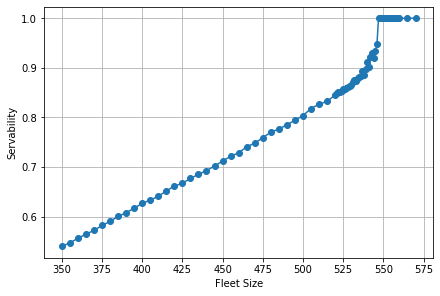

In [86]:
from matplotlib.ticker import MaxNLocator
%matplotlib inline

fig, ax = plt.subplots(constrained_layout=True)

ax.plot(fleet_list, serviced_fracts, "o-")
m = (serviced_fracts[-1] - serviced_fracts[0])/100
b = serviced_fracts[0]

# x_power = np.linspace(0,0.3,1000)
# ax.plot(x_power+546, serviced_fracts[np.where(fleet_list==546)[0]]+x_power**(1/popt[0]))

ax.set_xlabel("Fleet Size")
ax.set_ylabel("Servability")
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
# fig.suptitle(r"$125\cdot 10^3$" + " requests " + r"$(\nu={}\,\mathrm{{s}}^{{-1}})$".format(round(125*10**3/(10*3600), 3)))
# ax.set_ylim(0,1.1)
# ax.set_xscale('log')
# ax.set_yscale('log')
ax.grid()

# fig.savefig("125e3ReqsUnimodal.jpg", dpi=200)
plt.show()

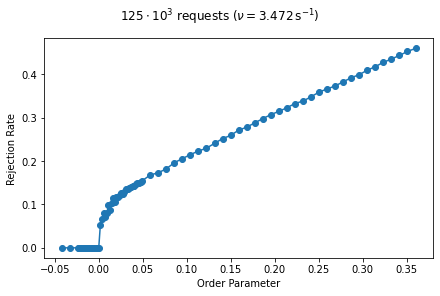

In [95]:
from matplotlib.ticker import MaxNLocator
from scipy.optimize import curve_fit
%matplotlib inline

fig, ax = plt.subplots(constrained_layout=True)

order_param = (fleet_list-547)/547
# idx = np.where(order_param < 0)
idx = np.s_[:]
order_param = -order_param[idx]
rejections = (1-serviced_fracts)[idx]

# x_log = np.log(order_param)
# y_log = np.log(serv_fracts_mod)
# def linFit(x, a):
#     return a*x
# popt, pcov = curve_fit(linFit, x_log[-3:], y_log[-3:])
# print(popt, pcov)
# print("Critical Exponent: ", popt[0])

ax.plot(order_param, rejections, "o-")
# ax.plot(order_param, order_param**popt[0])
ax.plot()

# ax.set_xscale('log')
# ax.set_yscale('log')
ax.set_xlabel("Order Parameter")
ax.set_ylabel("Rejection Rate")
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
fig.suptitle(r"$125\cdot 10^3$" + " requests " + r"$(\nu={}\,\mathrm{{s}}^{{-1}})$".format(round(125*10**3/(10*3600), 3)))

# fig.savefig("125e3ReqsUnimodal.jpg", dpi=200)
plt.show()

[0.47717401] [[4.19133075e-05]]
Critical Exponent:  0.47717400864653925


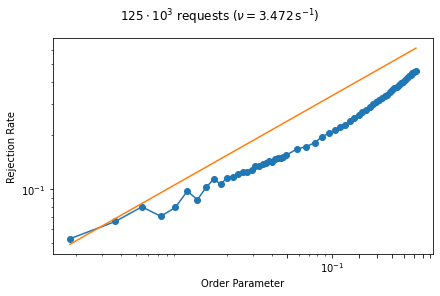

In [94]:
from matplotlib.ticker import MaxNLocator
from scipy.optimize import curve_fit
%matplotlib inline

fig, ax = plt.subplots(constrained_layout=True)

order_param = (fleet_list-547)/547
# order_param = fleet_list
idx = np.where(order_param < 0)
# idx = np.s_[:]
order_param = -order_param[idx]
serv_fracts_mod = (1-serviced_fracts)[idx]

x_log = np.log(order_param)
y_log = np.log(serv_fracts_mod)
def linFit(x, a):
    return a*x
popt, pcov = curve_fit(linFit, x_log[-3:], y_log[-3:])
print(popt, pcov)
print("Critical Exponent: ", popt[0])

ax.plot(order_param, serv_fracts_mod, "o-")
ax.plot(order_param, order_param**popt[0])
ax.plot()

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel("Order Parameter")
ax.set_ylabel("Rejection Rate")
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
fig.suptitle(r"$125\cdot 10^3$" + " requests " + r"$(\nu={}\,\mathrm{{s}}^{{-1}})$".format(round(125*10**3/(10*3600), 3)))

# fig.savefig("125e3ReqsUnimodal.jpg", dpi=200)
plt.show()

In [ ]:
fig, ax = plt.subplots(constrained_layout=True)

ax.plot(fleet_list, av_drt_occs, 'o-')

ax.set_xlabel("Fleet Size")

plt.show()

In [ ]:
fig, ax = plt.subplots(constrained_layout=True)

ax.plot(fleet_list, av_detours, 'o-')

ax.set_xlabel("Fleet Size")

plt.show()

In [ ]:
fig, ax = plt.subplots(constrained_layout=True)

ax.plot(fleet_list, av_drt_occs/av_detours, 'o-')

ax.set_xlabel("Fleet Size")

plt.show()

In [ ]:
fig, ax = plt.subplots(constrained_layout=True)

#Normalize by TT for private car
ax.plot(fleet_list, tt_bimodal_rescaled, 'o-')

ax.set_xlabel("Fleet Size")

plt.show()

In [ ]:
fig, ax = plt.subplots(constrained_layout=True)

#Normalize by TT for private car
ax.plot(fleet_list, wait_times_rescaled, 'o-')

ax.set_xlabel("Fleet Size")

plt.show()

In [ ]:
fig, ax = plt.subplots(constrained_layout=True)

ax.plot(fleet_list, standing_fractions, 'o-')

ax.set_xlabel("Fleet Size")

plt.show()

In [ ]:
fig, ax = plt.subplots(constrained_layout=True)

ax.plot(fleet_list, cummulative_drt_bimodal_rescaled, 'o-')

ax.set_xlabel("Fleet Size")

plt.show()

In [ ]:
def isParetoEfficient(costs):
    is_efficient = np.ones(costs.shape[0], dtype = bool)
    for i, c in enumerate(costs):
        is_efficient[i] = np.all(np.any(costs[:i]>c, axis=1)) and np.all(np.any(costs[i+1:]>c, axis=1))
    return is_efficient

In [ ]:
costs = np.stack((cummulative_drt_bimodal_rescaled, tt_bimodal_rescaled), axis=1)

In [ ]:
%matplotlib inline

pareto_efficient = isParetoEfficient(costs)
fig, ax = plt.subplots(constrained_layout=True)

scatter = ax.scatter(cummulative_drt_bimodal_rescaled, tt_bimodal_rescaled, c=pareto_efficient)
# ax.plot(cummulative_drt_bimodal_rescaled, tt_bimodal_rescaled)
handles, labels = scatter.legend_elements()
labels = ["pareto unoptimal", "pareto optimal"]

ax.set_xlabel("driven_distance_bimodal / driven_distance_car")
ax.set_ylabel("tt_bimodal / tt_car")
ax.legend(handles, labels)
# fig.colorbar(scatter)

plt.show()

In [ ]:
x = np.linspace(0.0001,10,100)
y = np.sqrt(x)
log_x = np.log(x)
log_y = np.log(y)

plt.figure()

plt.plot(log_x,log_y)
plt.grid()

plt.show()

print("Exp: 1/2")